# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: Maryam Abbasi, Alireza Shahrivarrahimi
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed

In [ ]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [ ]:
batch_size = 625

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Load the data and transform the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)


# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

100%|██████████| 170498071/170498071 [00:02<00:00, 65760901.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_mean = train_dataset.data.mean(axis=(0, 1, 2)) / 255
train_std = train_dataset.data.std(axis=(0, 1, 2)) / 255
print("Mean:", train_mean)
print("Std:", train_std)


from torch.utils.data import DataLoader

# Define data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)


Mean: [0.49139968 0.48215841 0.44653091]
Std: [0.24703223 0.24348513 0.26158784]


In [ ]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    # Extract a batch of images and labels from the data loader
    images, labels = next(iter(dl))

    # Create a grid of images
    grid = torchvision.utils.make_grid(images, nrow=8)

    # Denormalize the images
    denorm = transforms.Normalize((-train_mean / train_std).tolist(), (1.0 / train_std).tolist())
    denormalized_grid = denorm(grid)

    # Convert the images to numpy arrays
    images_np = denormalized_grid.permute(1, 2, 0).numpy()

    # Plot the images with labels
    plt.figure(figsize=(12, 6))
    plt.imshow(images_np)
    plt.axis('off')
    plt.title('Batch of Images')
    plt.show()

    # Print the labels
    print('Labels:', labels.tolist())


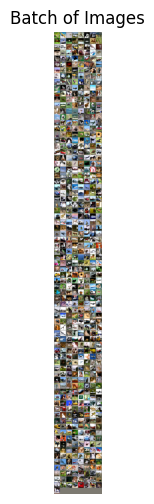

Labels: [6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3, 2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8, 2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8, 6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7, 0, 1, 2, 3, 4, 6, 5, 9, 3, 5, 8, 8, 2, 6, 5, 0, 0, 2, 2, 0, 4, 4, 5, 2, 8, 7, 4, 7, 2, 2, 0, 3, 9, 7, 9, 6, 6, 8, 4, 9, 4, 2, 6, 4, 3, 3, 6, 5, 1, 1, 5, 0, 3, 0, 0, 7, 2, 3, 9, 3, 6, 8, 7, 9, 9, 1, 6, 2, 1, 4, 2, 9, 5, 3, 0, 1, 8, 0, 7, 5, 5, 5, 7, 2, 3, 3, 5, 7, 2, 0, 3, 3, 3, 8, 5, 3, 5, 8, 3, 7, 5, 7, 2, 3, 3, 3, 6, 1, 5, 9, 1, 6, 8, 7, 3, 0, 8, 0, 4, 8, 1, 9, 3, 2, 8, 3, 7, 0, 8, 9, 2, 6, 8, 1, 8, 9, 2, 3, 0, 2, 1, 6, 3, 3, 4, 4, 5, 3, 8, 9, 7, 6, 8, 6, 1, 8, 3, 9, 8, 6, 7, 8, 8, 5, 9, 2, 7, 6, 4, 4, 0, 2, 2, 9, 2, 8, 6, 0, 5, 4, 9, 0, 8, 8, 9, 8, 5, 0, 0, 7, 3, 2, 5, 3, 6, 6, 4, 4, 2, 5, 2, 6, 0, 7, 3, 4, 1, 3, 8, 3, 4, 5, 8, 9, 7, 4, 5, 5, 8, 8, 7, 2, 9, 5, 5, 8, 3, 3, 7, 6, 5, 9, 9, 8, 7

In [ ]:
import torchvision

show_batch(train_loader)

In [ ]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [ ]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total):
    """
    Function to calculate the accuracy given the number of correctly classified samples
    and the total number of samples.
    Returns the accuracy ratio.
    """
    return correct / total


In [ ]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Method to train the model."""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        

    train_loss /= len(dataloader)
    accuracy = 100.0 * correct / total

    return train_loss, accuracy


def validate(dataloader, model, loss_fn, device, master_bar):
    """Method to compute the metrics on the validation set."""
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            valid_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # Update progress bar
            #master_bar.child.comment = f"Validation Loss: {valid_loss / (batch_idx + 1):.4f}"

    valid_loss /= len(dataloader)
    accuracy = 100.0 * correct / total

    return valid_loss, accuracy

    

In [ ]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange

def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """Method to run the training procedure."""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    master_bar = trange(num_epochs, desc='Epoch')
    for epoch in master_bar:
        # Training
        train_loss, train_accuracy = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation
        val_loss, val_accuracy = validate(val_dataloader, model, loss_function, device, master_bar)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)

        # Update progress bar description
        master_bar.set_postfix(train_loss=train_loss, val_loss=val_loss, train_acc=train_accuracy, val_acc=val_accuracy)

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """Method to compute the confusion values on the validation set."""
    model.eval()
    confusion_matrix = torch.zeros(10, 10, dtype=torch.int64).to(device)

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            for i in range(len(target)):
                confusion_matrix[target[i], predicted[i]] += 1

    return confusion_matrix

    

## Logistic Regression   

In [ ]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """Initializes internal Module state."""
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """Defines the computation performed at every call."""
        x = x.view(x.size(0), -1)  # Flatten the input to a suitable size for the initial layer
        outputs = self.linear(x)
        return outputs

In [ ]:
input_dim = 32 * 32 * 3  # Assuming CIFAR-10 images are 32x32 pixels with 3 channels
output_dim = 10  # CIFAR-10 has 10 output classes

linear_regression = LR(input_dim, output_dim)
linear_regression = linear_regression.to(device)
linear_regression.train()


LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [ ]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [ ]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()


In [ ]:
num_epochs = 20
## TODO: run training over 20 epochs
train_losses, val_losses, train_accs, val_accs = run_training(linear_regression, optimizer, loss_function, device, num_epochs, train_loader, test_loader)


Epoch: 100%|██████████| 20/20 [05:55<00:00, 17.77s/it, train_acc=41.4, train_loss=1.71, val_acc=38.9, val_loss=1.75]


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 1650)
        self.fc2 = torch.nn.Linear(1650, 512)
        self.fc3 = torch.nn.Linear(512, 138)
        self.fc4 = torch.nn.Linear(138, output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)  # Flatten the input
        out = self.relu(self.fc1(xb))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out


In [ ]:
## TODO: Define network, put it to device and train mode

network = MLP(input_dim, output_dim)
network = network.to(device)
network.train()


MLP(
  (fc1): Linear(in_features=3072, out_features=1650, bias=True)
  (fc2): Linear(in_features=1650, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=138, bias=True)
  (fc4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
## TODO: Define optimizer and loss functions
learning_rate = 0.001  
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()


In [ ]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
train_losses, val_losses, train_accs, val_accs = run_training(network, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

## Add L2 regularisation

In [ ]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
import torch
import torch.nn as nn
import torch.optim as optim




class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Define the layers and architecture of LeNet-5 model
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 16 * 5 * 5)  
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x



learning_rate = 0.001  # Define the learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet5()
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
    

In [ ]:
## TODO: Retrain new model with regularization over 20 epochs

num_epochs = 20
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
loss_function = nn.CrossEntropyLoss()
train_losses, val_losses, train_accs, val_accs = run_training(model, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

## LeNet5

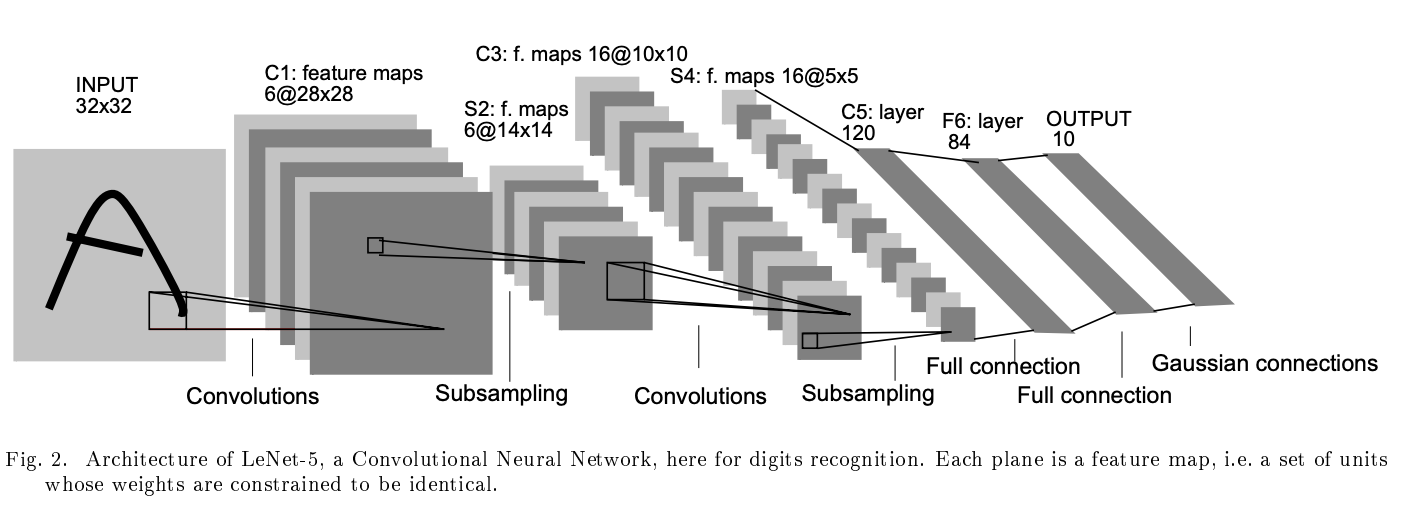

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [ ]:
class LeNet5(nn.Module):
    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## TODO: define network, put it to the device and train mode
network = LeNet5(n_classes=10, in_channels=3)  # Assuming 10 classes for CIFAR-10 dataset and 3 input channels for RGB images
network = network.to(device)
network.train()

In [ ]:
## TODO: define loss function and optimisers
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
## TODO: train with 20 epochs
num_epochs = 20
train_losses, val_losses, train_accs, val_accs = run_training(network, optimizer, loss_function, device, num_epochs, train_loader, test_loader)


## Analysis 

In [3]:
## TODO: Plot both train and val losses for all models. 
# Plotting training and validation losses for all models
plt.figure(figsize=(10, 5))

# Logistic Regression Model
plt.plot(train_losses_lr, label='Logistic Regression (Train)')
plt.plot(val_losses_lr, label='Logistic Regression (Validation)')

# MLP Model
#plt.plot(train_losses_mlp, label='MLP (Train)')
#plt.plot(val_losses_mlp, label='MLP (Validation)')

# LeNet-5 Model
#plt.plot(train_losses_lenet5, label='LeNet-5 (Train)')
#plt.plot(val_losses_lenet5, label='LeNet-5 (Validation)')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()




## What do you see?

NameError: ignored

<Figure size 1000x500 with 0 Axes>

In [2]:
# Plotting training and validation accuracies for all models
plt.figure(figsize=(10, 5))

# Logistic Regression Model
plt.plot(train_accs_lr, label='Logistic Regression (Train)')
plt.plot(val_accs_lr, label='Logistic Regression (Validation)')

# MLP Model
# TODO: Obtain train_accs_mlp and val_accs_mlp for MLP model
plt.plot(train_accs_mlp, label='MLP (Train)')
plt.plot(val_accs_mlp, label='MLP (Validation)')

# LeNet-5 Model
# TODO: Obtain train_accs_lenet5 and val_accs_lenet5 for LeNet-5 model
plt.plot(train_accs_lenet5, label='LeNet-5 (Train)')
plt.plot(val_accs_lenet5, label='LeNet-5 (Validation)')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

## What do you see?

NameError: ignored

<Figure size 1000x500 with 0 Axes>

100%|██████████| 9912422/9912422 [00:00<00:00, 459405200.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 80918967.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93402455.25it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 23063594.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Train Loss: 0.2568, Val Loss: 0.0676
Epoch [2/10], Train Loss: 0.0670, Val Loss: 0.0583
Epoch [3/10], Train Loss: 0.0489, Val Loss: 0.0398
Epoch [4/10], Train Loss: 0.0392, Val Loss: 0.0426
Epoch [5/10], Train Loss: 0.0340, Val Loss: 0.0343
Epoch [6/10], Train Loss: 0.0276, Val Loss: 0.0354
Epoch [7/10], Train Loss: 0.0243, Val Loss: 0.0369
Epoch [8/10], Train Loss: 0.0210, Val Loss: 0.0362
Epoch [9/10], Train Loss: 0.0212, Val Loss: 0.0303
Epoch [10/10], Train Loss: 0.0158, Val Loss: 0.0367


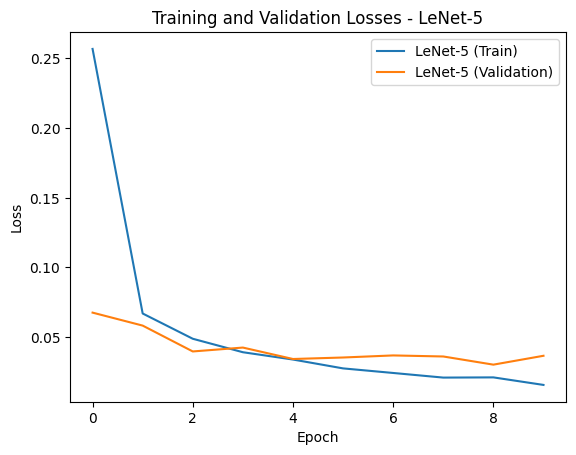

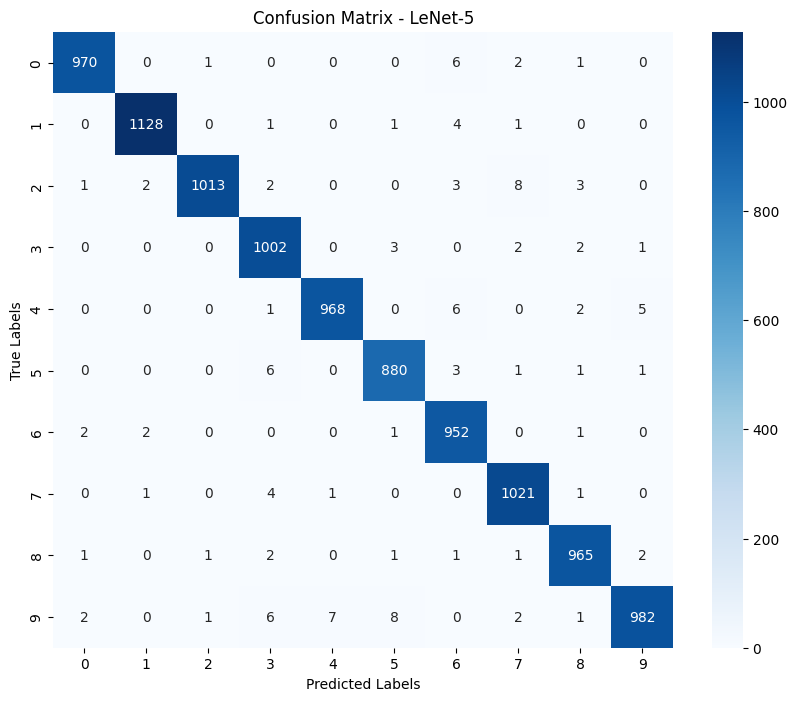

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# LeNet-5 Model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize LeNet-5 model
lenet5_model = LeNet5().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet5_model.parameters(), lr=learning_rate)

# Training loop
train_losses_lenet5 = []
val_losses_lenet5 = []

for epoch in range(num_epochs):
    lenet5_model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = lenet5_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses_lenet5.append(train_loss)

    # Validation
    lenet5_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = lenet5_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(test_loader.dataset)
    val_losses_lenet5.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(train_losses_lenet5, label='LeNet-5 (Train)')
plt.plot(val_losses_lenet5, label='LeNet-5 (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - LeNet-5')
plt.legend()
plt.show()

# Evaluation
lenet5_model.eval()
test_correct_lenet5 = 0
predictions_lenet5 = []
true_labels_lenet5 = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = lenet5_model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct_lenet5 += (predicted == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        predictions_lenet5.extend(predicted.tolist())
        true_labels_lenet5.extend(labels.tolist())

test_accuracy_lenet5 = 100.0 * test_correct_lenet5 / len(test_loader.dataset)

# Compute confusion matrix
confusion_mat_lenet5 = confusion_matrix(true_labels_lenet5, predictions_lenet5)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_lenet5, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LeNet-5')
plt.show()


## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
